In [1]:
from huggingface_hub import from_pretrained_keras
import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np

c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
img_path = '../test_data/004__beschluss-der-bundesregierung-vom-24-marz-1950-abschrift-aus-dem-kurzprotokoll-der-52-kabinettssitzung-der-bundesregierung.jpg'
img = imageio.imread(img_path)
plt.imshow(img)

C:\Users\phili\AppData\Local\Temp\ipykernel_9348\2698443811.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [4]:
model_name = "SBB/eynollah-textline"
model = from_pretrained_keras(model_name)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 6013.34it/s]


c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [42]:
#model.summary()

In [26]:
cropped_img = img[:448,:672]
cropped_img = np.expand_dims(cropped_img, 0)

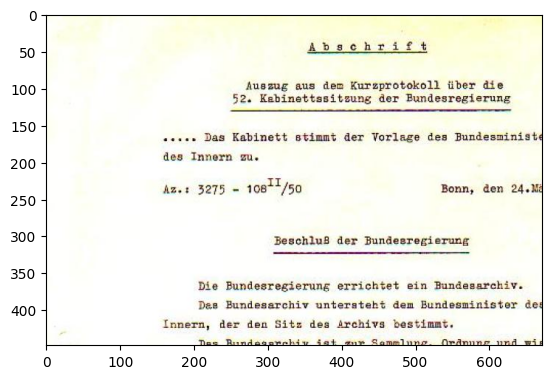

In [27]:
plt.imshow(cropped_img[0])

In [28]:
pred = model.predict(cropped_img/255)

1/1 [==============================] - 1s 1s/step


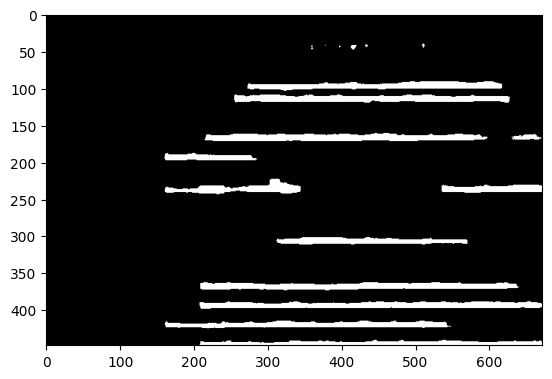

In [29]:
seg = np.argmax(pred, axis=3)[0]
seg_color = np.repeat(seg[:, :, np.newaxis], 3, axis=2)
plt.imshow(seg_color*255)

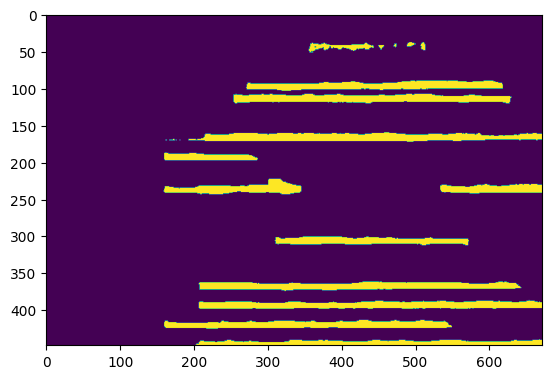

In [30]:
plt.imshow(pred[0,...,1]>.1)

In [31]:
def resize_image(img_in,input_height,input_width):
    return cv2.resize( img_in, ( input_width,input_height) ,interpolation=cv2.INTER_NEAREST)

In [32]:
def return_scaled_image(img, num_col, width_early, model_name):
    num_col = 1
    if num_col == 1 and width_early < 1100:
        img_w_new = 2000
        img_h_new = int(img.shape[0] / float(img.shape[1]) * 2000)
    img_new = resize_image(img, img_h_new, img_w_new)

    return img_new

In [33]:
def visualize_model_output(prediction, img, model_name):
    unique_classes = np.unique(prediction[:,:,0])
    rgb_colors = {'0' : [255, 255, 255],
                    '1' : [255, 0, 0],
                    '2' : [255, 125, 0],
                    '3' : [255, 0, 125],
                    '4' : [125, 125, 125],
                    '5' : [125, 125, 0],
                    '6' : [0, 125, 255],
                    '7' : [0, 125, 0],
                    '8' : [125, 125, 125],
                    '9' : [0, 125, 255],
                    '10' : [125, 0, 125],
                    '11' : [0, 255, 0],
                    '12' : [0, 0, 255],
                    '13' : [0, 255, 255],
                    '14' : [255, 125, 125],
                    '15' : [255, 0, 255]}

    output = np.zeros(prediction.shape)

    for unq_class in unique_classes:
        rgb_class_unique = rgb_colors[str(int(unq_class))]
        output[:,:,0][prediction[:,:,0]==unq_class] = rgb_class_unique[0]
        output[:,:,1][prediction[:,:,0]==unq_class] = rgb_class_unique[1]
        output[:,:,2][prediction[:,:,0]==unq_class] = rgb_class_unique[2]

    img = resize_image(img, output.shape[0], output.shape[1])

    output = output.astype(np.int32)
    img = img.astype(np.int32)
    
    added_image = cv2.addWeighted(img,0.5,output,0.1,0)
        
    return added_image

In [40]:
def do_line_segmentation(model_name, img):

    img_org = np.copy(img)
    #model = from_pretrained_keras(model_name)

    # bitmap output
    img_height_model=model.layers[len(model.layers)-1].output_shape[1]
    img_width_model=model.layers[len(model.layers)-1].output_shape[2]
    #n_classes=model.layers[len(model.layers)-1].output_shape[3]

    #img_org = np.copy(img)
    #img_height_h = img_org.shape[0]
    #img_width_h = img_org.shape[1]

    num_col_classifier = 1 # return_num_columns(img)
    width_early = img.shape[1]

    img = return_scaled_image(img, num_col_classifier, width_early, model_name)

    if img.shape[0] < img_height_model:
        img = resize_image(img, img_height_model, img.shape[1])

    if img.shape[1] < img_width_model:
        img = resize_image(img, img.shape[0], img_width_model)

    marginal_of_patch_percent = 0.1
    margin = int(marginal_of_patch_percent * img_height_model)
    width_mid = img_width_model - 2 * margin
    height_mid = img_height_model - 2 * margin
    img = img / float(255.0)
    img = img.astype(np.float16)
    img_h = img.shape[0]
    img_w = img.shape[1]
    prediction_true = np.zeros((img_h, img_w, 3))
    #mask_true = np.zeros((img_h, img_w))
    nxf = img_w / float(width_mid)
    nyf = img_h / float(height_mid)
    nxf = int(nxf) + 1 if nxf > int(nxf) else int(nxf)
    nyf = int(nyf) + 1 if nyf > int(nyf) else int(nyf)

    for i in range(nxf):
        for j in range(nyf):
            if i == 0:
                index_x_d = i * width_mid
                index_x_u = index_x_d + img_width_model
            else:
                index_x_d = i * width_mid
                index_x_u = index_x_d + img_width_model
            if j == 0:
                index_y_d = j * height_mid
                index_y_u = index_y_d + img_height_model
            else:
                index_y_d = j * height_mid
                index_y_u = index_y_d + img_height_model
            if index_x_u > img_w:
                index_x_u = img_w
                index_x_d = img_w - img_width_model
            if index_y_u > img_h:
                index_y_u = img_h
                index_y_d = img_h - img_height_model

            img_patch = img[index_y_d:index_y_u, index_x_d:index_x_u, :]

            label_p_pred = model.predict(img_patch.reshape(1, img_patch.shape[0], img_patch.shape[1], img_patch.shape[2]),
                                            verbose=0)
                
            seg = np.argmax(label_p_pred, axis=3)[0]
            seg_color = np.repeat(seg[:, :, np.newaxis], 3, axis=2)

            if i == 0 and j == 0:
                seg_color = seg_color[0 : seg_color.shape[0] - margin, 0 : seg_color.shape[1] - margin, :]
                prediction_true[index_y_d + 0 : index_y_u - margin, index_x_d + 0 : index_x_u - margin, :] = seg_color
            elif i == nxf - 1 and j == nyf - 1:
                seg_color = seg_color[margin : seg_color.shape[0] - 0, margin : seg_color.shape[1] - 0, :]
                prediction_true[index_y_d + margin : index_y_u - 0, index_x_d + margin : index_x_u - 0, :] = seg_color
            elif i == 0 and j == nyf - 1:
                seg_color = seg_color[margin : seg_color.shape[0] - 0, 0 : seg_color.shape[1] - margin, :]
                prediction_true[index_y_d + margin : index_y_u - 0, index_x_d + 0 : index_x_u - margin, :] = seg_color
            elif i == nxf - 1 and j == 0:
                seg_color = seg_color[0 : seg_color.shape[0] - margin, margin : seg_color.shape[1] - 0, :]
                prediction_true[index_y_d + 0 : index_y_u - margin, index_x_d + margin : index_x_u - 0, :] = seg_color
            elif i == 0 and j != 0 and j != nyf - 1:
                seg_color = seg_color[margin : seg_color.shape[0] - margin, 0 : seg_color.shape[1] - margin, :]
                prediction_true[index_y_d + margin : index_y_u - margin, index_x_d + 0 : index_x_u - margin, :] = seg_color
            elif i == nxf - 1 and j != 0 and j != nyf - 1:
                seg_color = seg_color[margin : seg_color.shape[0] - margin, margin : seg_color.shape[1] - 0, :]
                prediction_true[index_y_d + margin : index_y_u - margin, index_x_d + margin : index_x_u - 0, :] = seg_color
            elif i != 0 and i != nxf - 1 and j == 0:
                seg_color = seg_color[0 : seg_color.shape[0] - margin, margin : seg_color.shape[1] - margin, :]
                prediction_true[index_y_d + 0 : index_y_u - margin, index_x_d + margin : index_x_u - margin, :] = seg_color
            elif i != 0 and i != nxf - 1 and j == nyf - 1:
                seg_color = seg_color[margin : seg_color.shape[0] - 0, margin : seg_color.shape[1] - margin, :]
                prediction_true[index_y_d + margin : index_y_u - 0, index_x_d + margin : index_x_u - margin, :] = seg_color
            else:
                seg_color = seg_color[margin : seg_color.shape[0] - margin, margin : seg_color.shape[1] - margin, :]
                prediction_true[index_y_d + margin : index_y_u - margin, index_x_d + margin : index_x_u - margin, :] = seg_color

    prediction_true = prediction_true.astype(np.uint8)
    return prediction_true

In [41]:
pred = do_line_segmentation(model_name, img)

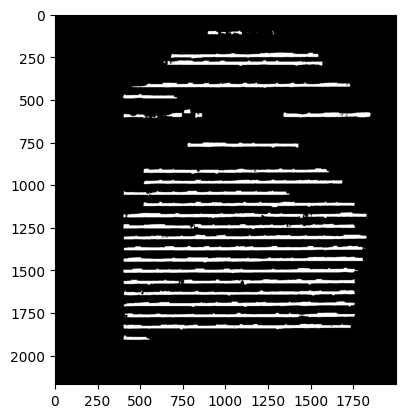

In [36]:
plt.imshow(pred*255)

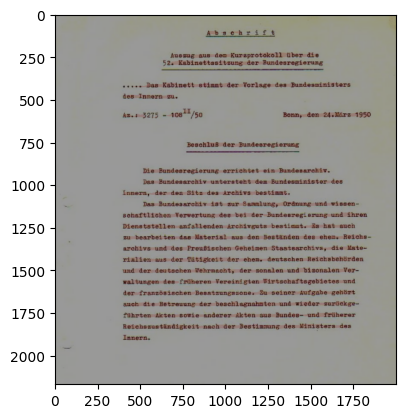

In [38]:
plt.imshow(visualize_model_output(pred, img, model_name))